In [1]:
#BASIC MODULES
import re
import os
import string
import numpy as np
import pandas as pd
import seaborn as sn
from numpy import array
import matplotlib.pyplot as plt

#MODULE FOR STRATIFIED K-FOLD CROSS-VALIDATION
from sklearn.model_selection import StratifiedKFold

#KERAS MODULES FOR NN MODELS
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from nltk.stem import WordNetLemmatizer

#MODULES FOR DISPLAY PURPOSES
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', 100000000)
pd.set_option('display.max_info_columns', 100000000)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

#HIDE REPEATING WARNING
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
#IMPORT DATA AND DROP DUPLICATES
df = pd.read_excel('train.xlsx')
df = df.drop_duplicates('Sentence')

#NUMERIZE SENTIMENT
polarity = {'positive': 1,'negative': 0} 
df['Sentiment'] = [polarity[item] for item in df.Sentiment] 

#BALANCE SENTIMENT
pos = df[df.Sentiment==1].sample(n = len(df[df.Sentiment==0]))
neg = df[df.Sentiment==0]
df = pos.append(neg)
df.Sentiment.value_counts()

1    1683
0    1683
Name: Sentiment, dtype: int64

In [3]:
#NORMALIZE TEXT DATA

#SHUFFLE
df = df.sample(frac=1).reset_index(drop=True)

#LOWER CASE
df['Sentence2'] = [x.lower() for x in df.Sentence]

#CONTRACTIONS
def decontracted(phrase):
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
df['Sentence2'] = [decontracted(x) for x in df['Sentence2']]


#REMOVE PUNCTUATION
df['Sentence2'] = df['Sentence2'].str.replace("[^a-zA-Z#]", " ")
df['Sentence2'] = [x.replace("\\n",'') for x in df.Sentence2]

#TOKENIZE - FOR NLTK
df['Sentence2'] = [x.split() for x in df.Sentence2]

#LEMENZIE - NLTK
wordnet_lemmatizer = WordNetLemmatizer()
def lem(words):
    return [wordnet_lemmatizer.lemmatize(word,pos="v") for word in words]
df['Sentence2'] = [lem(x) for x in df['Sentence2']]
df['Sentence2'] = [" ".join(x) for x in df.Sentence2]

#FIND NUMBER OF WORDS IN EACH ENTRY
df['length'] = [len(x.split()) for x in df.Sentence2]
df = df[['Sentence','Sentence2','length','Sentiment']]
df.head(2)

,Sentence,Sentence2,length,Sentiment
0,good value and extremely helpful and courteous staff.,good value and extremely helpful and courteous staff,8,1
1,It was very easy to complete and answer all the questions and everything was clear and the final payment much cheaper than the quote from my previous insurer.,it be very easy to complete and answer all the question and everything be clear and the final payment much cheaper than the quote from my previous insurer,28,1


In [4]:
#FIND NUMBER OF UNIQUE WORDS
allwords = df.Sentence2.values.tolist()
vocab_size = len(list(set(" ".join(allwords).split())))
vocab_size

3376

In [5]:
#GET FROM DATAFRAME
X = df['Sentence2'].values.tolist()
y = df['Sentiment'].values

#CONVERT WORDS TO NUMBERS
X_encoded = [one_hot(d, vocab_size) for d in X]

#PADDING OUT ARRAYS TO LENGTH OF LONGEST ARRAY
max_length = df['length'].max()+10 # plus 10 TO ACCOUNT FOR EXTRA WORDS DURING TESTING
X_padded = pad_sequences(X_encoded, maxlen=max_length, padding='post')

In [6]:
#DISPLAY VARIOUS STAGES OF DATA TRANSFORMATION
print(X[1],"\n")
print(X_encoded[1],"\n")
print(X_padded[1])

it be very easy to complete and answer all the question and everything be clear and the final payment much cheaper than the quote from my previous insurer 

[1095, 3008, 1276, 631, 3317, 2356, 2275, 1707, 2116, 1436, 16, 2275, 3196, 3008, 2691, 2275, 1436, 304, 3341, 80, 617, 1593, 1436, 2060, 1071, 2939, 334, 685] 

[1095 3008 1276  631 3317 2356 2275 1707 2116 1436   16 2275 3196 3008
 2691 2275 1436  304 3341   80  617 1593 1436 2060 1071 2939  334  685
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  

In [8]:
#K-FOLDS SPLITTING
kf = StratifiedKFold(5, shuffle=True, random_state=42)
scores = pd.DataFrame(columns = ['Dimensions','Epochs','Fold','Val_Acc','Val_Loss'])
val_acc_scores = []
val_loss_scores = []
fold = 0
for train, val in kf.split(X_padded,df['Sentiment']):
    fold+=1
    print(f"Fold #{fold}")
    X_train = X_padded[train]
    y_train = y[train]
    X_val = X_padded[val]
    y_val = y[val]
    
    #dims = [10,20,40,80,160,320]
    dims = [80] # YIELDS BEST RESULTS
    for dim in dims:
        #BUILD NN
        model = Sequential()
        model.add(Embedding(vocab_size, dim, input_length=max_length))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        #EARLY STOPPING
        Callbacks = EarlyStopping(monitor='val_loss', 
                                                  min_delta=0.00001, 
                                                  patience=5, 
                                                  verbose=0, 
                                                  mode='auto')
        
        #COMPILE NN
        model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        
        #RUN MODEL AND RECORD METRICS    
        history = model.fit(X_train, y_train,
                        batch_size=1,
                        epochs=999,
                        callbacks = [Callbacks],
                        validation_data=(X_val, y_val),verbose=1)
        
        dictionary = {'Dimensions':dim, 'Epochs':len(history.history['val_accuracy']),'Fold':fold, 'Val_Acc':history.history['val_accuracy'][0],'Val_Loss':history.history['val_loss'][0]}
        scores = scores.append(dictionary, ignore_index=True)
        print()

Fold #1
Train on 2692 samples, validate on 674 samples
Epoch 1/999
2692/2692 [==============================] - 6s 2ms/step - loss: 0.4860 - accuracy: 0.7671 - val_loss: 0.3834 - val_accuracy: 0.8427
Epoch 2/999
2692/2692 [==============================] - 6s 2ms/step - loss: 0.3494 - accuracy: 0.8704 - val_loss: 0.4027 - val_accuracy: 0.8635
Epoch 3/999
2692/2692 [==============================] - 6s 2ms/step - loss: 0.2962 - accuracy: 0.8908 - val_loss: 0.4494 - val_accuracy: 0.8620
Epoch 4/999
2692/2692 [==============================] - 5s 2ms/step - loss: 0.2545 - accuracy: 0.9134 - val_loss: 0.4610 - val_accuracy: 0.8605
Epoch 5/999
2692/2692 [==============================] - 5s 2ms/step - loss: 0.2055 - accuracy: 0.9316 - val_loss: 0.5145 - val_accuracy: 0.8694
Epoch 6/999
2692/2692 [==============================] - 6s 2ms/step - loss: 0.1689 - accuracy: 0.9461 - val_loss: 0.5467 - val_accuracy: 0.8561

Fold #2
Train on 2692 samples, validate on 674 samples
Epoch 1/999
2692/26

In [9]:
#COLLATING RESULTS
averages = pd.DataFrame(columns=['Dimension','Epoch Avg','Val_Acc Avg','Val_Loss Avg'])
for dim in dims:
    results = scores[scores.Dimensions==dim]
    display(results)
    results.pop('Fold')
    results.pop('Dimensions')
    dictionary = {'Dimension':dim,'Epoch Avg':results.Epochs.describe()[1],'Val_Acc Avg':results.Val_Acc.describe()[1],'Val_Loss Avg':results.Val_Loss.describe()[1]}
    averages = averages.append(dictionary, ignore_index=True)
averages

,Dimensions,Epochs,Fold,Val_Acc,Val_Loss
0,80.0,6.0,1.0,0.842730,0.383363
1,80.0,6.0,2.0,0.826410,0.407365
2,80.0,6.0,3.0,0.827893,0.393098
3,80.0,6.0,4.0,0.860119,0.348564
4,80.0,6.0,5.0,0.822917,0.399791


,Dimension,Epoch Avg,Val_Acc Avg,Val_Loss Avg
0,80.0,6.0,0.836014,0.386436


In [10]:
#CREATE PIPLINE TO TEST MODEL ON INPUT SENTENCES:
def predict(x):
    x = x.lower()
    x = decontracted(x)
    x = re.sub(r'[^\w\s]','',x)
    x = "".join(lem(x))
    x = one_hot(x, vocab_size)
    while len(x)<max_length:
        x.append(0)
    x = np.array(x)
    x = x.reshape(1,-1)
    return int(round(model.predict(x)[0][0],0))

In [11]:
#EXAMPLE
print(predict('good customer service'))
print(predict('bad customer service'))

1
0


In [12]:
#RUNNING MODEL ON UNLABELED TEST DATASET
test_df = pd.read_excel('test.xlsx')
test_df['Prediction'] = [predict(x) for x in test_df['Sentence']]
test_df.sample(n=5)

,Sentence,Entity,Prediction
814,so far i have never had a problem with them.,problem,0
1102,quotes online it is the reason i chose axa insurance services,insurance,0
1262,"some high value benefits can just disappear, like non-smoker cashback of £150 a year.",benefits,1
909,because the billing is sometimes a hassle,hassle,0
549,Having compared many different car insurers I was pleasantly surprised to find that my current insurers was one of best prices quoted I had expected it to have increased.,prices,1


Precision:  0.92
Recall:  0.93
f1:  0.46


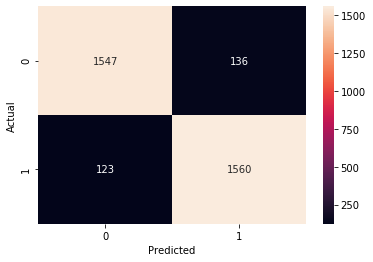

In [13]:
#RUNNING MODEL ON TRAINING SET TO COMPARE PREDICTIONS WITH GROUND TRUTHS
df['Prediction'] = [predict(x) for x in df.Sentence]
confusion_matrix = pd.crosstab(df['Sentiment'], df['Prediction'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True,fmt='g')
true_pos = confusion_matrix[1][1]
true_neg = confusion_matrix[0][0]
false_pos = confusion_matrix[1][0]
false_neg = confusion_matrix[0][1]

precision = (true_pos)/(true_pos+false_pos)
recall = (true_pos)/(true_pos+false_neg)
f1 = (precision*recall)/(precision+recall)

print('Precision: ',round(precision,2))
print('Recall: ',round(recall,2))
print('f1: ',round(f1,2))

In [14]:
#ANALYSING WHERE THE MODEL PREDICTED INCORRECTLY
def result(x,y):
    if x==0 and y ==0:
        return "TN"
    if x==0 and y==1:
        return 'FP'
    if x==1 and y ==1:
        return "TP"
    if x==1 and y==0:
        return 'FN'
    
df['Result'] = [result(x,y) for x,y in zip(df.Sentiment,df.Prediction)]
df =df[['Sentence','Sentiment','Prediction','Result']]
df[(df.Result=='FP') | (df.Result=='FN')].sample(n=5)

,Sentence,Sentiment,Prediction,Result
2330,A good quote but very annoying to have to telephone you at the end of the internet process and go through most of the in formation again!,0,1,FP
2096,The ease of uploading of no claims proof speeds up the process.,1,0,FN
369,When I asked questions she gave me clear answers and the rationale behind it it.,1,0,FN
3127,Told them what i required and what i didnt - great price and service,0,1,FP
2695,Really disappointed that for the most genuine of reasons at the age of 50 after 32 years of driving i am told i cannot add a temporary car to my policy !!!,0,1,FP
